/var/folders/lm/w5v6vwl91955r0nc47_mqt88flhqcv/T/ipykernel_46856/1283056416.py:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


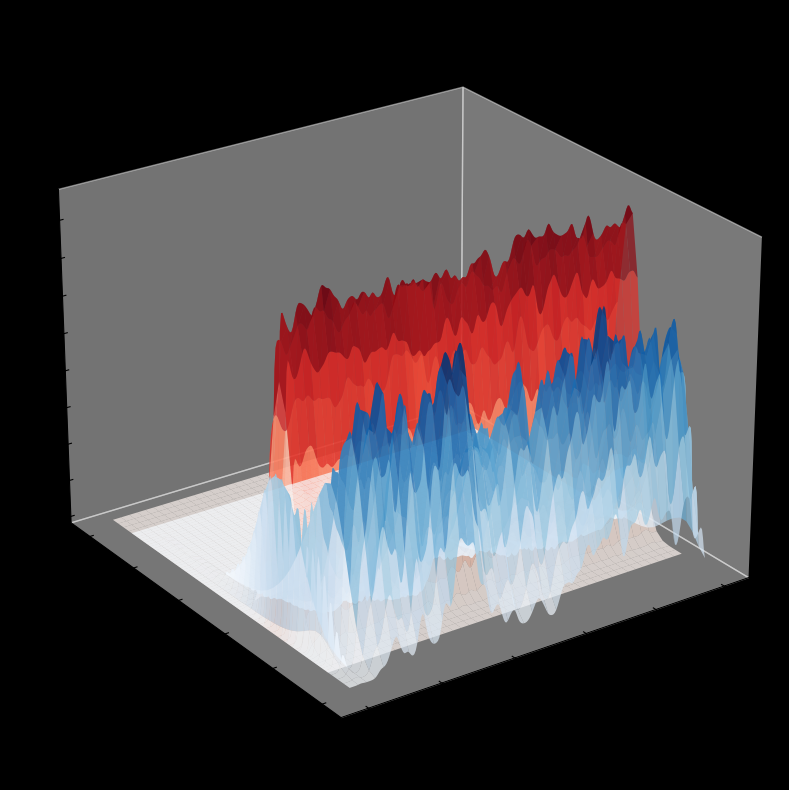

In [32]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

df_nasdaq = pd.read_parquet('../../data/raw/nasdaq_daily.parquet')
df_sim = pd.read_parquet('../../data/raw/sim_daily.parquet')

def prep_vol_data(df, window=30):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['returns'] = df.groupby('symbol')['close'].pct_change()
    df['volatility'] = df.groupby('symbol')['returns'].rolling(window).std().reset_index(0, drop=True) * np.sqrt(252)
    return df

def create_smooth_surface(df, dates, vols, sigma=1.5):
    z = np.zeros((len(dates), len(vols)-1))
    for i, date in enumerate(dates):
        start_date = date
        end_date = date + pd.Timedelta(days=7)
        mask = (df['date'] >= start_date) & (df['date'] < end_date)
        daily_vols = df[mask]['volatility'].dropna()
        if len(daily_vols) > 0:
            hist, _ = np.histogram(daily_vols, bins=vols, density=True)
            z[i] = hist * len(daily_vols)
    return gaussian_filter(z, sigma=sigma)

nasdaq_prep = prep_vol_data(df_nasdaq)
sim_prep = prep_vol_data(df_sim)

dates = pd.date_range(start='2020-01-01', end='2025-02-01', freq='W')
max_vol = max(nasdaq_prep['volatility'].max(), sim_prep['volatility'].max())
vols = np.linspace(0, max_vol * 1.1, 40)

z_nasdaq = create_smooth_surface(nasdaq_prep, dates, vols)
z_sim = create_smooth_surface(sim_prep, dates, vols)

fig = plt.figure(figsize=(15, 10), facecolor='black')
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')

x, y = np.meshgrid(np.arange(len(dates)), vols[:-1])

surf1 = ax.plot_surface(x.T, y.T, z_nasdaq, alpha=0.7, cmap='Blues', 
                       antialiased=True, shade=True)
surf2 = ax.plot_surface(x.T, y.T + max_vol*0.1, z_sim, alpha=0.7, cmap='Reds', 
                       antialiased=True, shade=True)

ax.set_xlabel('Time', labelpad=10)
ax.set_ylabel('Volatility', labelpad=10)
ax.set_zlabel('Frequency', labelpad=10)

date_ticks = np.linspace(0, len(dates)-1, 6, dtype=int)
ax.set_xticks(date_ticks)
ax.set_xticklabels([dates[i].strftime('%Y-%m') for i in date_ticks], rotation=30)

ax.view_init(elev=25, azim=235)
ax.grid(False)

plt.tight_layout()
plt.show()